In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import os

In [7]:
directory="C:/Users/ameya/OneDrive - University of Pittsburgh/Eclipse/DataFiles/OctData/LS-3"
Data=np.zeros((2,2))
startindex=10
endindex=startindex+30
for i in range(startindex,endindex):
    #print(i)
    path=os.path.join(directory,"LSdate0_"+str(i)+".txt")
    df=np.loadtxt(path,delimiter="\t")
    Data=np.concatenate((Data,df.T),axis=1)
print(Data)
Data[1]=Data[1]-Data[1][0]
Data[0]=Data[0]/2

[[0.00000000e+00 0.00000000e+00 2.87298683e+00 ... 2.48797784e+00
  2.48800000e+00 2.48802216e+00]
 [0.00000000e+00 0.00000000e+00 1.69729505e+09 ... 1.69730408e+09
  1.69730408e+09 1.69730408e+09]]


In [8]:
index=2
newVData=Data[0][index:-1]
newTData=Data[1][index:-1]-Data[1][index]
newData=np.array([newVData.T,newTData.T])
print(newData)

[[1.43649341e+00 1.43650898e+00 1.43651707e+00 ... 1.24401677e+00
  1.24398892e+00 1.24400000e+00]
 [0.00000000e+00 2.37107277e-03 4.69684601e-03 ... 9.02297062e+03
  9.02297297e+03 9.02297531e+03]]


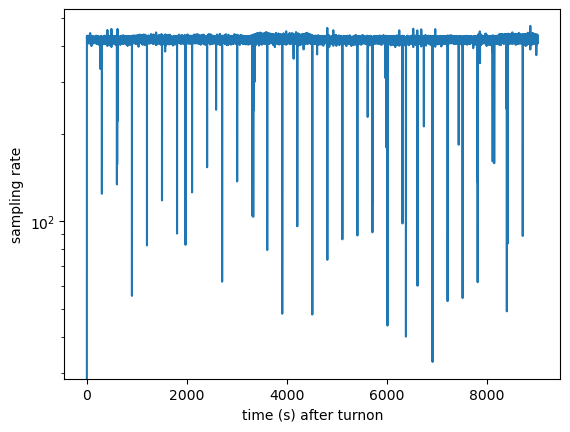

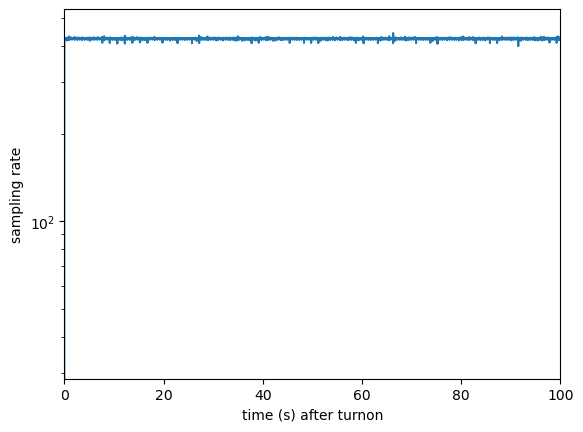

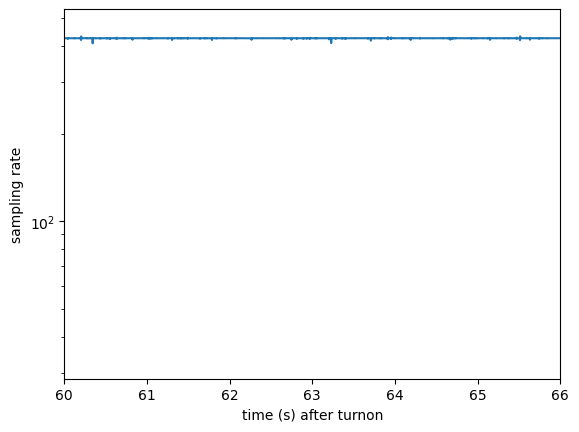

In [13]:
timediff=np.concatenate((np.array([0]),1/np.diff(newData[1])))
srate=1/np.mean(timediff)
plt.plot(newData[1],timediff)
plt.yscale("log")
#plt.ylim(3E2,3E3)
plt.xlabel("time (s) after turnon")
plt.ylabel("sampling rate")
plt.show()
plt.plot(newData[1],timediff)
plt.yscale("log")
#plt.ylim(3E2,3E3)
plt.xlim(0,100)
plt.xlabel("time (s) after turnon")
plt.ylabel("sampling rate")
plt.show()
plt.plot(newData[1],timediff)
plt.yscale("log")
#plt.ylim(3E2,3E3)
plt.xlim(60,66)
plt.xlabel("time (s) after turnon")
plt.ylabel("sampling rate")
plt.show()

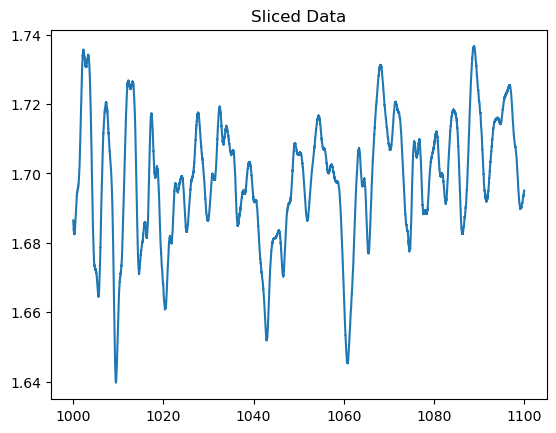

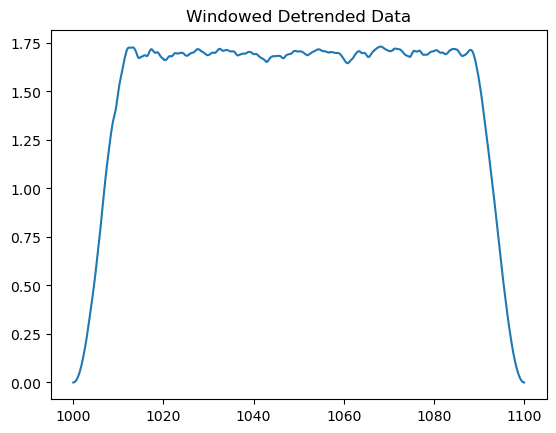

NameError: name 'sRate' is not defined

In [14]:
startindex=np.where(newData[1]>1000)[0][0]
endindex=np.where(newData[1]>1100)[0][0]
plt.plot(newData[1][startindex:endindex],newData[0][startindex:endindex])
plt.title("Sliced Data")
plt.show()

windowedD=scipy.signal.tukey(len(newData[0][startindex:endindex]),0.25)*newData[0][startindex:endindex]
plt.plot(newData[1][startindex:endindex],windowedD)
plt.title("Windowed Detrended Data")
plt.show()

freq=scipy.fft.rfftfreq(len(newData[0][startindex:endindex]))
val=np.abs(scipy.fft.rfft(windowedD))
plt.plot(freq*sRate,val)
plt.yscale("log")
plt.xlim(0,5)
plt.title("FFT")
plt.show()

result=scipy.signal.lombscargle(newData[1][startindex:endindex],windowedD,np.linspace(0.01,1,100)*(2*np.pi))
plt.plot(np.linspace(0.01,1,100),result)
plt.title("LombScarg")
plt.yscale("log")
plt.show()

freq=scipy.fft.rfftfreq(len(newData[0][startindex:endindex]))
val=np.abs(scipy.fft.rfft(windowedD))
plt.plot(freq*sRate,val)
plt.yscale("log")
plt.title("FFT")
plt.xlim(0,100)
plt.show()

result=scipy.signal.lombscargle(newData[1][startindex:endindex],windowedD,np.linspace(0.01,100,1000)*(2*np.pi))
plt.plot(np.linspace(0.01,100,1000),result)
plt.title("LombScarg")
plt.yscale("log")
plt.show()


In [ ]:
timeDiff=np.diff(newData[1])
plt.hist(timeDiff,bins=100)
plt.yscale("log")
plt.show()
tInt=np.mean(timeDiff)
sRate=1/tInt


In [ ]:
plt.hist(timeDiff,bins=100,range=(tInt-0.0001,tInt*2))
print(len(np.where(timeDiff>tInt*2)[0]))
plt.yscale("log")
plt.show()

In [ ]:
slicestart=np.where(newData[1]>1200)[0][0]
endstart=np.where(newData[1]>1300)[0][0]
w=5*400
dStds=np.std(np.lib.stride_tricks.sliding_window_view(newData[0][slicestart:endstart], w),axis=1)
print(dStds)
plt.plot(dStds)
plt.yscale("log")
plt.show()

In [ ]:
def returnPeriodigram(x,t,fs,nperseg,noverlap,window,mode):
    if(len(x)!=len(t)):
        raise ValueError("lenx!=lent")
    if mode not in ["fourier","lombscargle"]:
        raise ValueError("Check Mode")
    if window not in ["hann","tukey"]:
        raise ValueError("Check Window")   
    
    windowSize=nperseg
    
    if window == "hann":
        windowArray=np.hanning(windowSize)
    if window =="tukey":
        windowArray=scipy.signal.windows.tukey(windowSize,0.25)
    divisionPoints,maxI=newDataDivider(x,t,nperseg,noverlap)

    times=np.arange(nperseg/2, x.shape[-1] - nperseg/2 + 1, nperseg - noverlap)/float(fs)
    freqs=scipy.fft.rfftfreq(nperseg,1/fs)
    
    Sxx=np.zeros((len(times),len(freqs)))
    
    if (mode=="fourier"):
        for i in range(0,maxI):
            slicedX,slicedT=prepData(x,t,windowArray,i,divisionPoints)
            result=np.abs(oneColumnFFT(scipy.signal.detrend(slicedX)))
            Sxx[i]=result
            
    if(mode=="lombscargle"):
        freqs[0]=0.001
        for i in range(0,maxI):
            slicedX,slicedT=prepData(x,t,windowArray,i,divisionPoints)
            result=scipy.signal.lombscargle(slicedT,scipy.signal.detrend(slicedX),2*np.pi*freqs,precenter=True)
            Sxx[i]=result
    
    
    return freqs,times,Sxx.T

def newDataDivider(x,t,nperseg,noverlap):
    divides=[]
    step=nperseg-noverlap
    for i in range(0,(len(x)-nperseg)//step):
        divides.append(step*i)
        divides.append(step*i+nperseg)
    return divides,len(divides)//2


def prepData(x,t,window,i,divides):
    sliceStart=divides[2*i]
    sliceEnd=divides[2*i+1]
    newX=window*x[sliceStart:sliceEnd]
    newT=t[sliceStart:sliceEnd]
        
    return newX,newT

def oneColumnFFT(slicedX):
    return scipy.fft.rfft(slicedX)

In [ ]:
fs=2400
nperseg=3*64
noverlap=nperseg//8
sampt=3*np.sort(np.random.rand(3*fs))
#sampt=3*np.linspace(0,1,3*fs)
sampx=np.sin(5*2*np.pi*sampt)+np.sin(80*2*np.pi*sampt)+0.2*np.random.rand(len(sampt))+np.sin(sampt*150*2*np.pi*sampt)
plt.plot(sampt,sampx)
plt.show()
fmy,tmy,Sxxmy=returnPeriodigram(sampx,sampt,fs,nperseg,noverlap,"tukey","fourier")


plt.pcolormesh(tmy, fmy, Sxxmy,cmap="gray")
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("mine")
plt.show()

f, t, Sxx = scipy.signal.spectrogram(sampx, fs,nperseg=nperseg,noverlap=noverlap)

plt.pcolormesh(t, f, Sxx,cmap="gray")
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("scipy")
plt.show()

result=scipy.signal.lombscargle(sampt,sampx,np.linspace(1,90,100)*(2*np.pi))
plt.plot(np.linspace(1,90,100),result)
plt.show()

fmy,tmy,Sxxmy=returnPeriodigram(sampx,sampt,fs,nperseg,noverlap,"tukey","lombscargle")


plt.pcolormesh(tmy, fmy, Sxxmy,cmap="gray")
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("mine")
plt.show()


C:\Users\ameya\anaconda3\envs\phys1321\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


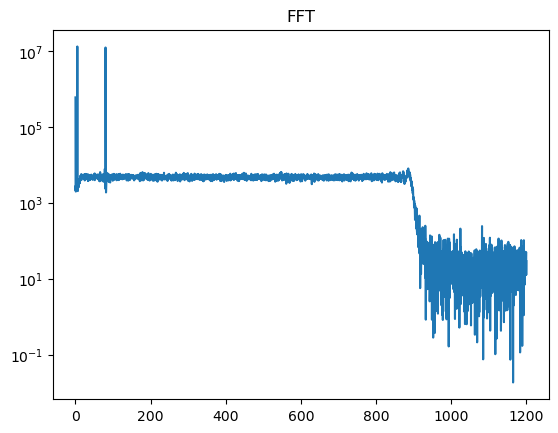

In [128]:
freq=scipy.fft.rfftfreq(len(sampx))
val=oneColumnFFT(sampx)
val=val*np.conjugate(val)
plt.plot(freq*fs,val)
plt.yscale("log")
plt.title("FFT")
plt.show()

In [96]:
def dataDivider(x,t,nperseg,noverlap):
    divides=[]
    divides.append(0)
    divides.append(nperseg+2*noverlap)
    divDone=False
    while not divDone:
        divides.append(divides[-1]-noverlap)
        divides.append(divides[-1]+2*noverlap+nperseg)
        if(divides[-1]>len(x)):
            divDone=True
            divides=divides[:-2]
    return divides, int(len(divides)/2)

def scipyDataDivider(x,nperseg,noverlap):
    step = nperseg - noverlap
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//step, nperseg)
    strides = x.strides[:-1]+(step*x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                                 strides=strides)
    print(step)
    print(shape)
    print(strides)
    print(result)
    return result


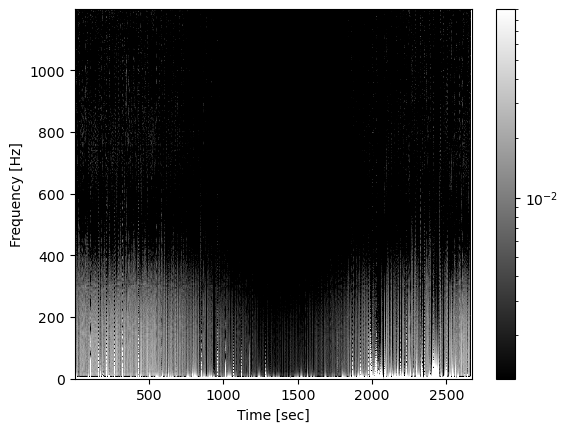

In [76]:
fmy,tmy,Sxxmy=returnPeriodigram(newData[0],newData[1],sRate,2*int(sRate),2*int(sRate//8),"tukey","lombscargle")
plt.pcolormesh(tmy, fmy, Sxxmy,norm=colors.LogNorm(vmin=Sxx.mean(), vmax=Sxx.max()),cmap="gray")
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

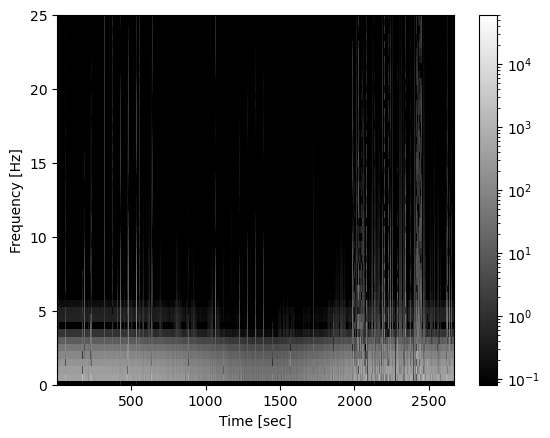

In [77]:
plt.pcolormesh(tmy, fmy, Sxxmy,norm=colors.LogNorm(vmin=5e7*Sxx.mean(), vmax=Sxx.max()),cmap="gray")
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,25)
plt.show()